# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

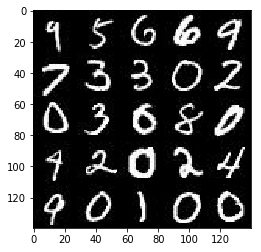

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

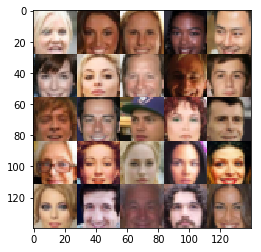

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)

    return real, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [80]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        # 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 7x7x128
        
        # Flatten it
        flat = tf.reshape(x, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [81]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [82]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [83]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [84]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [88]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.0373... Generator Loss: 0.0925
Epoch 1/2... Discriminator Loss: 2.3780... Generator Loss: 0.2263
Epoch 1/2... Discriminator Loss: 1.9601... Generator Loss: 0.4130
Epoch 1/2... Discriminator Loss: 2.2996... Generator Loss: 0.3558
Epoch 1/2... Discriminator Loss: 1.6230... Generator Loss: 0.5688
Epoch 1/2... Discriminator Loss: 1.6570... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 1.7193... Generator Loss: 0.4343
Epoch 1/2... Discriminator Loss: 1.7243... Generator Loss: 0.4353
Epoch 1/2... Discriminator Loss: 1.3193... Generator Loss: 0.5872
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.7451


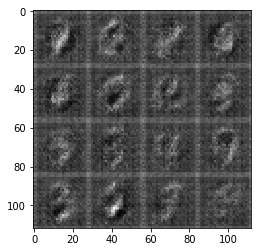

Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 1.2246
Epoch 1/2... Discriminator Loss: 0.8736... Generator Loss: 1.0904
Epoch 1/2... Discriminator Loss: 0.6357... Generator Loss: 1.4715
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 0.9026
Epoch 1/2... Discriminator Loss: 0.7866... Generator Loss: 1.0046
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.3919
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 2.6157
Epoch 1/2... Discriminator Loss: 0.7849... Generator Loss: 1.3003
Epoch 1/2... Discriminator Loss: 0.8726... Generator Loss: 1.2834


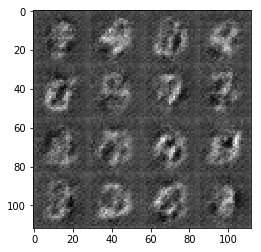

Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.4136
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 0.6187... Generator Loss: 1.3712
Epoch 1/2... Discriminator Loss: 0.6465... Generator Loss: 1.4631
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 0.6175
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.5431... Generator Loss: 0.3111
Epoch 1/2... Discriminator Loss: 0.6390... Generator Loss: 2.2878
Epoch 1/2... Discriminator Loss: 1.3325... Generator Loss: 0.3913
Epoch 1/2... Discriminator Loss: 0.8178... Generator Loss: 0.8062


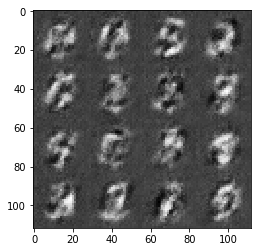

Epoch 1/2... Discriminator Loss: 0.7079... Generator Loss: 1.5965
Epoch 1/2... Discriminator Loss: 0.7476... Generator Loss: 1.7881
Epoch 1/2... Discriminator Loss: 0.4933... Generator Loss: 1.5160
Epoch 1/2... Discriminator Loss: 0.5038... Generator Loss: 1.5863
Epoch 1/2... Discriminator Loss: 0.6354... Generator Loss: 2.2143
Epoch 1/2... Discriminator Loss: 0.6024... Generator Loss: 1.1396
Epoch 1/2... Discriminator Loss: 0.7499... Generator Loss: 0.8435
Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 0.6434
Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 0.4945
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 1.9232


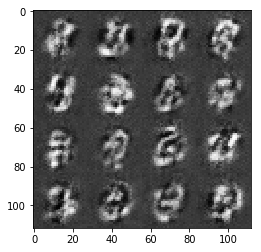

Epoch 1/2... Discriminator Loss: 0.8788... Generator Loss: 0.6975
Epoch 1/2... Discriminator Loss: 0.6524... Generator Loss: 1.0355
Epoch 1/2... Discriminator Loss: 0.7361... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 0.5791
Epoch 1/2... Discriminator Loss: 0.4763... Generator Loss: 2.5362
Epoch 1/2... Discriminator Loss: 0.6532... Generator Loss: 0.9793
Epoch 1/2... Discriminator Loss: 0.5126... Generator Loss: 1.3386
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 4.0986
Epoch 1/2... Discriminator Loss: 0.2998... Generator Loss: 1.9614
Epoch 1/2... Discriminator Loss: 0.3469... Generator Loss: 1.8156


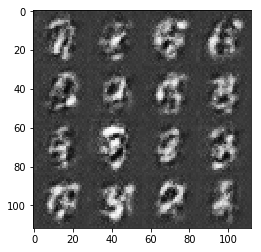

Epoch 1/2... Discriminator Loss: 0.4655... Generator Loss: 1.2919
Epoch 1/2... Discriminator Loss: 0.5277... Generator Loss: 1.2883
Epoch 1/2... Discriminator Loss: 0.4003... Generator Loss: 3.5633
Epoch 1/2... Discriminator Loss: 0.3953... Generator Loss: 1.5274
Epoch 1/2... Discriminator Loss: 0.3304... Generator Loss: 2.3119
Epoch 1/2... Discriminator Loss: 0.4493... Generator Loss: 3.0108
Epoch 1/2... Discriminator Loss: 0.2743... Generator Loss: 1.9293
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 0.8896
Epoch 1/2... Discriminator Loss: 0.3714... Generator Loss: 2.4816
Epoch 1/2... Discriminator Loss: 0.4288... Generator Loss: 1.3999


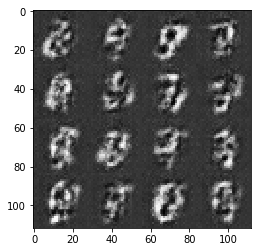

Epoch 1/2... Discriminator Loss: 0.3366... Generator Loss: 2.5314
Epoch 1/2... Discriminator Loss: 0.4392... Generator Loss: 3.2854
Epoch 1/2... Discriminator Loss: 0.4449... Generator Loss: 4.1280
Epoch 1/2... Discriminator Loss: 0.4490... Generator Loss: 4.1390
Epoch 1/2... Discriminator Loss: 0.3180... Generator Loss: 3.6927
Epoch 1/2... Discriminator Loss: 0.2929... Generator Loss: 2.1601
Epoch 1/2... Discriminator Loss: 0.3145... Generator Loss: 3.4622
Epoch 1/2... Discriminator Loss: 0.2030... Generator Loss: 2.7678
Epoch 1/2... Discriminator Loss: 0.4298... Generator Loss: 2.2524
Epoch 1/2... Discriminator Loss: 0.2810... Generator Loss: 2.4867


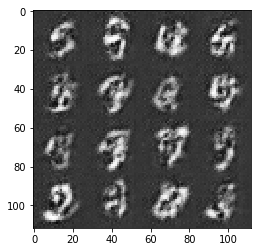

Epoch 1/2... Discriminator Loss: 0.2601... Generator Loss: 2.9270
Epoch 1/2... Discriminator Loss: 0.2778... Generator Loss: 2.4395
Epoch 1/2... Discriminator Loss: 0.2740... Generator Loss: 1.8495
Epoch 1/2... Discriminator Loss: 0.4917... Generator Loss: 2.8976
Epoch 1/2... Discriminator Loss: 0.5838... Generator Loss: 2.4125
Epoch 1/2... Discriminator Loss: 0.1701... Generator Loss: 4.6715
Epoch 1/2... Discriminator Loss: 0.1914... Generator Loss: 4.9154
Epoch 1/2... Discriminator Loss: 0.5051... Generator Loss: 1.0776
Epoch 1/2... Discriminator Loss: 0.4083... Generator Loss: 1.3836
Epoch 1/2... Discriminator Loss: 0.4352... Generator Loss: 1.4524


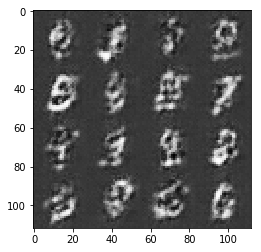

Epoch 1/2... Discriminator Loss: 0.1416... Generator Loss: 4.4365
Epoch 1/2... Discriminator Loss: 0.4598... Generator Loss: 5.8712
Epoch 1/2... Discriminator Loss: 0.2391... Generator Loss: 5.8330
Epoch 1/2... Discriminator Loss: 0.2824... Generator Loss: 2.1040
Epoch 1/2... Discriminator Loss: 0.4990... Generator Loss: 1.2318
Epoch 1/2... Discriminator Loss: 0.5190... Generator Loss: 1.1340
Epoch 1/2... Discriminator Loss: 0.2125... Generator Loss: 2.2364
Epoch 1/2... Discriminator Loss: 0.2028... Generator Loss: 4.0862
Epoch 1/2... Discriminator Loss: 0.6751... Generator Loss: 0.8757
Epoch 1/2... Discriminator Loss: 0.5180... Generator Loss: 1.0870


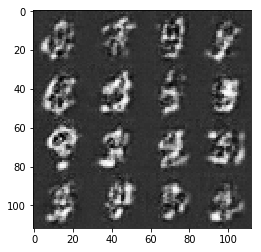

Epoch 1/2... Discriminator Loss: 0.6741... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 0.1791... Generator Loss: 3.3259
Epoch 1/2... Discriminator Loss: 0.3958... Generator Loss: 1.5730
Epoch 1/2... Discriminator Loss: 0.1750... Generator Loss: 4.1494
Epoch 1/2... Discriminator Loss: 0.5717... Generator Loss: 3.4820
Epoch 1/2... Discriminator Loss: 0.1356... Generator Loss: 4.0199
Epoch 1/2... Discriminator Loss: 0.6905... Generator Loss: 5.8389
Epoch 1/2... Discriminator Loss: 0.1226... Generator Loss: 4.2076
Epoch 1/2... Discriminator Loss: 0.1746... Generator Loss: 4.4397
Epoch 1/2... Discriminator Loss: 0.2701... Generator Loss: 4.1802


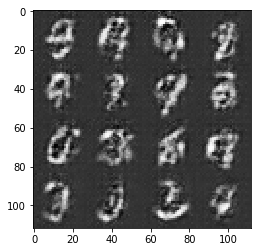

Epoch 1/2... Discriminator Loss: 0.3084... Generator Loss: 5.3329
Epoch 1/2... Discriminator Loss: 0.1859... Generator Loss: 2.7823
Epoch 1/2... Discriminator Loss: 0.3981... Generator Loss: 1.6130
Epoch 1/2... Discriminator Loss: 0.3631... Generator Loss: 1.4211
Epoch 1/2... Discriminator Loss: 0.1417... Generator Loss: 4.1469
Epoch 1/2... Discriminator Loss: 0.1467... Generator Loss: 2.4769
Epoch 1/2... Discriminator Loss: 0.4222... Generator Loss: 1.4469
Epoch 1/2... Discriminator Loss: 0.1173... Generator Loss: 4.1972
Epoch 1/2... Discriminator Loss: 0.2561... Generator Loss: 1.8020
Epoch 1/2... Discriminator Loss: 0.2392... Generator Loss: 4.4638


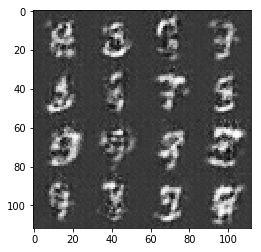

Epoch 1/2... Discriminator Loss: 0.1770... Generator Loss: 2.3985
Epoch 1/2... Discriminator Loss: 0.1039... Generator Loss: 3.3302
Epoch 1/2... Discriminator Loss: 0.1251... Generator Loss: 2.8035
Epoch 1/2... Discriminator Loss: 0.1659... Generator Loss: 6.1282
Epoch 1/2... Discriminator Loss: 0.0548... Generator Loss: 4.1040
Epoch 1/2... Discriminator Loss: 0.0439... Generator Loss: 4.6191
Epoch 1/2... Discriminator Loss: 0.1841... Generator Loss: 2.2581
Epoch 1/2... Discriminator Loss: 0.1941... Generator Loss: 2.2238
Epoch 1/2... Discriminator Loss: 0.2684... Generator Loss: 1.9091
Epoch 1/2... Discriminator Loss: 0.3977... Generator Loss: 1.3220


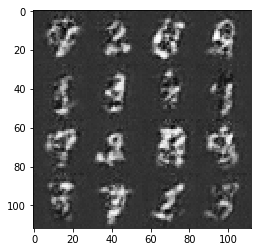

Epoch 1/2... Discriminator Loss: 0.1463... Generator Loss: 2.6307
Epoch 1/2... Discriminator Loss: 0.0879... Generator Loss: 3.0888
Epoch 1/2... Discriminator Loss: 0.0465... Generator Loss: 4.5548
Epoch 1/2... Discriminator Loss: 0.0896... Generator Loss: 4.2406
Epoch 1/2... Discriminator Loss: 0.1941... Generator Loss: 2.1783
Epoch 1/2... Discriminator Loss: 0.2246... Generator Loss: 2.0691
Epoch 1/2... Discriminator Loss: 0.1412... Generator Loss: 3.2012
Epoch 1/2... Discriminator Loss: 0.0634... Generator Loss: 4.4416
Epoch 1/2... Discriminator Loss: 0.2994... Generator Loss: 1.5909
Epoch 1/2... Discriminator Loss: 0.2367... Generator Loss: 5.9575


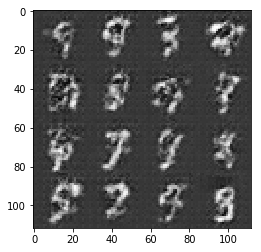

Epoch 1/2... Discriminator Loss: 0.0980... Generator Loss: 3.6540
Epoch 1/2... Discriminator Loss: 0.1862... Generator Loss: 4.8207
Epoch 1/2... Discriminator Loss: 0.7312... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 1.1708
Epoch 1/2... Discriminator Loss: 0.1638... Generator Loss: 4.6135
Epoch 1/2... Discriminator Loss: 0.1282... Generator Loss: 4.5610
Epoch 1/2... Discriminator Loss: 0.1052... Generator Loss: 3.6700
Epoch 1/2... Discriminator Loss: 0.4706... Generator Loss: 1.1848
Epoch 1/2... Discriminator Loss: 0.2898... Generator Loss: 1.8243
Epoch 1/2... Discriminator Loss: 0.1034... Generator Loss: 3.5560


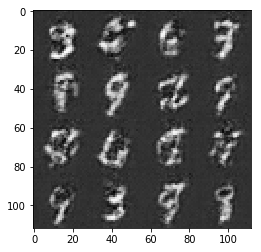

Epoch 1/2... Discriminator Loss: 0.0537... Generator Loss: 4.1025
Epoch 1/2... Discriminator Loss: 0.3119... Generator Loss: 1.5075
Epoch 1/2... Discriminator Loss: 0.0702... Generator Loss: 5.7578
Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 0.8795
Epoch 1/2... Discriminator Loss: 0.0474... Generator Loss: 6.1189
Epoch 1/2... Discriminator Loss: 0.3305... Generator Loss: 1.7783
Epoch 1/2... Discriminator Loss: 0.1007... Generator Loss: 3.3111
Epoch 1/2... Discriminator Loss: 0.1532... Generator Loss: 7.7925
Epoch 1/2... Discriminator Loss: 0.3068... Generator Loss: 1.7659
Epoch 1/2... Discriminator Loss: 0.1629... Generator Loss: 2.3165


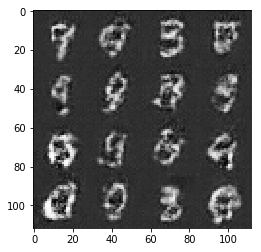

Epoch 1/2... Discriminator Loss: 0.0579... Generator Loss: 3.8593
Epoch 1/2... Discriminator Loss: 0.1185... Generator Loss: 4.2692
Epoch 1/2... Discriminator Loss: 0.4348... Generator Loss: 1.3585
Epoch 1/2... Discriminator Loss: 0.0550... Generator Loss: 4.2962
Epoch 1/2... Discriminator Loss: 0.1722... Generator Loss: 2.4160
Epoch 1/2... Discriminator Loss: 0.2351... Generator Loss: 1.8794
Epoch 1/2... Discriminator Loss: 0.5348... Generator Loss: 1.0972
Epoch 1/2... Discriminator Loss: 0.0707... Generator Loss: 4.4507
Epoch 1/2... Discriminator Loss: 0.1739... Generator Loss: 2.4844
Epoch 1/2... Discriminator Loss: 0.0845... Generator Loss: 5.1736


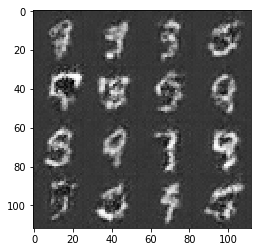

Epoch 1/2... Discriminator Loss: 0.1715... Generator Loss: 3.0114
Epoch 1/2... Discriminator Loss: 0.1304... Generator Loss: 3.6021
Epoch 1/2... Discriminator Loss: 0.2125... Generator Loss: 2.0003
Epoch 1/2... Discriminator Loss: 0.3441... Generator Loss: 1.5239
Epoch 1/2... Discriminator Loss: 0.4513... Generator Loss: 1.2809
Epoch 1/2... Discriminator Loss: 0.3623... Generator Loss: 1.4132
Epoch 1/2... Discriminator Loss: 0.1836... Generator Loss: 2.1806
Epoch 1/2... Discriminator Loss: 0.2764... Generator Loss: 1.6682
Epoch 1/2... Discriminator Loss: 0.2400... Generator Loss: 1.8851
Epoch 1/2... Discriminator Loss: 0.2735... Generator Loss: 1.8190


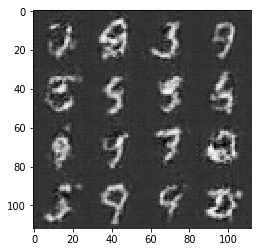

Epoch 1/2... Discriminator Loss: 0.1946... Generator Loss: 2.1885
Epoch 1/2... Discriminator Loss: 0.0733... Generator Loss: 4.4729
Epoch 1/2... Discriminator Loss: 0.1739... Generator Loss: 3.7862
Epoch 1/2... Discriminator Loss: 0.3119... Generator Loss: 1.8140
Epoch 1/2... Discriminator Loss: 0.1634... Generator Loss: 3.0201
Epoch 1/2... Discriminator Loss: 0.4170... Generator Loss: 4.7275
Epoch 1/2... Discriminator Loss: 0.2999... Generator Loss: 2.2226
Epoch 1/2... Discriminator Loss: 0.8200... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 0.1060... Generator Loss: 2.8671
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 1.0878


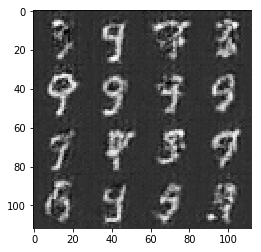

Epoch 1/2... Discriminator Loss: 0.1955... Generator Loss: 2.2321
Epoch 1/2... Discriminator Loss: 0.8281... Generator Loss: 0.6956
Epoch 1/2... Discriminator Loss: 0.1926... Generator Loss: 6.5260
Epoch 1/2... Discriminator Loss: 0.1206... Generator Loss: 3.3345
Epoch 1/2... Discriminator Loss: 0.0720... Generator Loss: 4.0270
Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 1.4051
Epoch 1/2... Discriminator Loss: 0.0669... Generator Loss: 4.5580
Epoch 2/2... Discriminator Loss: 0.0987... Generator Loss: 4.3129
Epoch 2/2... Discriminator Loss: 0.3244... Generator Loss: 1.5569
Epoch 2/2... Discriminator Loss: 0.4183... Generator Loss: 1.4277


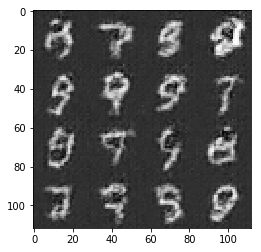

Epoch 2/2... Discriminator Loss: 0.5740... Generator Loss: 4.4081
Epoch 2/2... Discriminator Loss: 0.1790... Generator Loss: 2.3635
Epoch 2/2... Discriminator Loss: 0.1601... Generator Loss: 2.4503
Epoch 2/2... Discriminator Loss: 0.0860... Generator Loss: 5.7348
Epoch 2/2... Discriminator Loss: 0.1435... Generator Loss: 2.5948
Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 1.1186
Epoch 2/2... Discriminator Loss: 0.1413... Generator Loss: 2.8454
Epoch 2/2... Discriminator Loss: 0.0763... Generator Loss: 4.0017
Epoch 2/2... Discriminator Loss: 0.1050... Generator Loss: 3.8342
Epoch 2/2... Discriminator Loss: 0.2870... Generator Loss: 8.3131


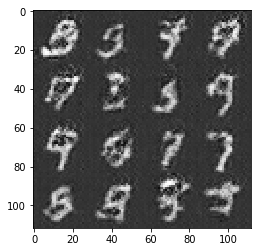

Epoch 2/2... Discriminator Loss: 0.3956... Generator Loss: 1.4484
Epoch 2/2... Discriminator Loss: 0.3051... Generator Loss: 1.7581
Epoch 2/2... Discriminator Loss: 0.4006... Generator Loss: 1.3760
Epoch 2/2... Discriminator Loss: 0.1982... Generator Loss: 2.1928
Epoch 2/2... Discriminator Loss: 0.1415... Generator Loss: 4.3013
Epoch 2/2... Discriminator Loss: 0.3128... Generator Loss: 1.9043
Epoch 2/2... Discriminator Loss: 0.2943... Generator Loss: 2.0543
Epoch 2/2... Discriminator Loss: 0.1295... Generator Loss: 2.6736
Epoch 2/2... Discriminator Loss: 0.1121... Generator Loss: 4.5533
Epoch 2/2... Discriminator Loss: 0.8422... Generator Loss: 0.7352


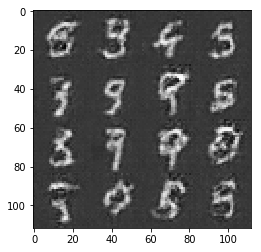

Epoch 2/2... Discriminator Loss: 0.0980... Generator Loss: 3.2123
Epoch 2/2... Discriminator Loss: 0.1224... Generator Loss: 2.6446
Epoch 2/2... Discriminator Loss: 0.0718... Generator Loss: 3.2009
Epoch 2/2... Discriminator Loss: 0.1318... Generator Loss: 2.9631
Epoch 2/2... Discriminator Loss: 0.1261... Generator Loss: 2.8795
Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 1.6551
Epoch 2/2... Discriminator Loss: 0.6503... Generator Loss: 1.0459
Epoch 2/2... Discriminator Loss: 0.2119... Generator Loss: 2.3782
Epoch 2/2... Discriminator Loss: 0.1825... Generator Loss: 2.1597
Epoch 2/2... Discriminator Loss: 0.1143... Generator Loss: 2.7220


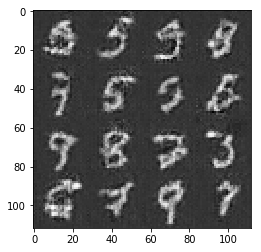

Epoch 2/2... Discriminator Loss: 0.3613... Generator Loss: 1.5593
Epoch 2/2... Discriminator Loss: 0.1345... Generator Loss: 2.6760
Epoch 2/2... Discriminator Loss: 0.0879... Generator Loss: 3.0025
Epoch 2/2... Discriminator Loss: 0.1474... Generator Loss: 2.5358
Epoch 2/2... Discriminator Loss: 0.1981... Generator Loss: 2.3756
Epoch 2/2... Discriminator Loss: 0.7832... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 0.0735... Generator Loss: 3.8219
Epoch 2/2... Discriminator Loss: 0.1006... Generator Loss: 5.2073
Epoch 2/2... Discriminator Loss: 0.2745... Generator Loss: 1.6861
Epoch 2/2... Discriminator Loss: 0.6136... Generator Loss: 5.2403


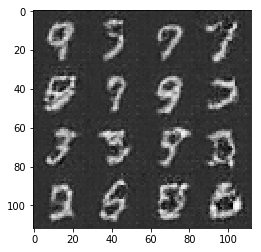

Epoch 2/2... Discriminator Loss: 0.1560... Generator Loss: 3.7726
Epoch 2/2... Discriminator Loss: 0.1349... Generator Loss: 2.6583
Epoch 2/2... Discriminator Loss: 0.0963... Generator Loss: 3.0754
Epoch 2/2... Discriminator Loss: 0.0559... Generator Loss: 5.6422
Epoch 2/2... Discriminator Loss: 0.1626... Generator Loss: 2.6050
Epoch 2/2... Discriminator Loss: 0.0554... Generator Loss: 3.9582
Epoch 2/2... Discriminator Loss: 0.2480... Generator Loss: 1.9319
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 3.9126
Epoch 2/2... Discriminator Loss: 0.2673... Generator Loss: 8.1275
Epoch 2/2... Discriminator Loss: 0.0395... Generator Loss: 5.4274


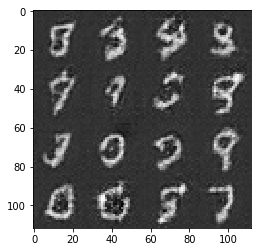

Epoch 2/2... Discriminator Loss: 0.1021... Generator Loss: 3.1745
Epoch 2/2... Discriminator Loss: 0.0589... Generator Loss: 4.6856
Epoch 2/2... Discriminator Loss: 0.0597... Generator Loss: 4.3985
Epoch 2/2... Discriminator Loss: 0.0766... Generator Loss: 4.2656
Epoch 2/2... Discriminator Loss: 0.1264... Generator Loss: 6.2272
Epoch 2/2... Discriminator Loss: 0.0450... Generator Loss: 6.5042
Epoch 2/2... Discriminator Loss: 1.4983... Generator Loss: 0.4207
Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 0.5165
Epoch 2/2... Discriminator Loss: 0.3868... Generator Loss: 1.8280
Epoch 2/2... Discriminator Loss: 0.2100... Generator Loss: 4.4820


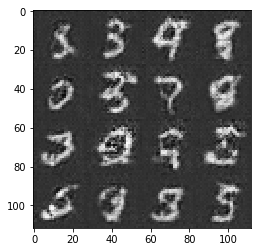

Epoch 2/2... Discriminator Loss: 0.1253... Generator Loss: 2.9035
Epoch 2/2... Discriminator Loss: 0.0920... Generator Loss: 3.8284
Epoch 2/2... Discriminator Loss: 1.4478... Generator Loss: 0.3265
Epoch 2/2... Discriminator Loss: 0.4438... Generator Loss: 2.4355
Epoch 2/2... Discriminator Loss: 0.1657... Generator Loss: 2.5166
Epoch 2/2... Discriminator Loss: 0.3574... Generator Loss: 1.5968
Epoch 2/2... Discriminator Loss: 0.1409... Generator Loss: 2.5239
Epoch 2/2... Discriminator Loss: 0.0886... Generator Loss: 4.0352
Epoch 2/2... Discriminator Loss: 0.0987... Generator Loss: 5.0884
Epoch 2/2... Discriminator Loss: 0.0459... Generator Loss: 6.5856


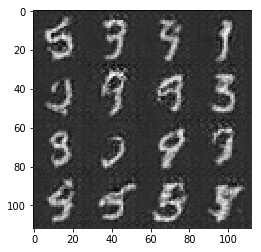

Epoch 2/2... Discriminator Loss: 0.1647... Generator Loss: 2.6489
Epoch 2/2... Discriminator Loss: 0.1172... Generator Loss: 3.1595
Epoch 2/2... Discriminator Loss: 0.0980... Generator Loss: 3.1300
Epoch 2/2... Discriminator Loss: 0.0867... Generator Loss: 3.0475
Epoch 2/2... Discriminator Loss: 0.1281... Generator Loss: 2.8836
Epoch 2/2... Discriminator Loss: 0.1034... Generator Loss: 2.9288
Epoch 2/2... Discriminator Loss: 0.4572... Generator Loss: 1.2361
Epoch 2/2... Discriminator Loss: 0.2385... Generator Loss: 2.0377
Epoch 2/2... Discriminator Loss: 0.3244... Generator Loss: 1.8210
Epoch 2/2... Discriminator Loss: 0.1331... Generator Loss: 2.7674


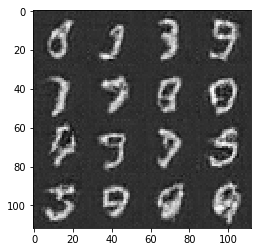

Epoch 2/2... Discriminator Loss: 0.0934... Generator Loss: 3.2429
Epoch 2/2... Discriminator Loss: 0.1053... Generator Loss: 4.1736
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 0.7712
Epoch 2/2... Discriminator Loss: 0.1318... Generator Loss: 3.2443
Epoch 2/2... Discriminator Loss: 0.0870... Generator Loss: 3.2213
Epoch 2/2... Discriminator Loss: 0.0664... Generator Loss: 3.4904
Epoch 2/2... Discriminator Loss: 0.0672... Generator Loss: 4.7720
Epoch 2/2... Discriminator Loss: 0.0436... Generator Loss: 5.5324
Epoch 2/2... Discriminator Loss: 0.3758... Generator Loss: 1.5551
Epoch 2/2... Discriminator Loss: 0.2012... Generator Loss: 2.2567


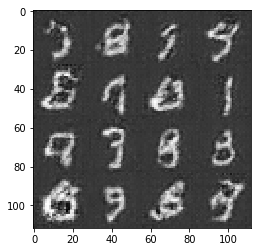

Epoch 2/2... Discriminator Loss: 0.0863... Generator Loss: 3.2664
Epoch 2/2... Discriminator Loss: 0.0724... Generator Loss: 4.8989
Epoch 2/2... Discriminator Loss: 0.5660... Generator Loss: 1.0424
Epoch 2/2... Discriminator Loss: 0.5785... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 0.1911... Generator Loss: 2.4564
Epoch 2/2... Discriminator Loss: 0.1230... Generator Loss: 4.7958
Epoch 2/2... Discriminator Loss: 0.1294... Generator Loss: 2.4797
Epoch 2/2... Discriminator Loss: 0.2140... Generator Loss: 1.9915
Epoch 2/2... Discriminator Loss: 0.0154... Generator Loss: 6.8955
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 3.9376


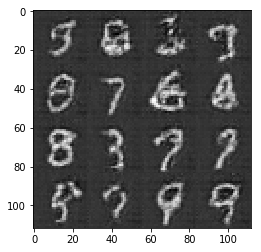

Epoch 2/2... Discriminator Loss: 0.3796... Generator Loss: 1.6953
Epoch 2/2... Discriminator Loss: 0.5343... Generator Loss: 1.1789
Epoch 2/2... Discriminator Loss: 0.1507... Generator Loss: 2.9514
Epoch 2/2... Discriminator Loss: 0.1889... Generator Loss: 2.2112
Epoch 2/2... Discriminator Loss: 0.3942... Generator Loss: 1.4470
Epoch 2/2... Discriminator Loss: 0.0824... Generator Loss: 3.4304
Epoch 2/2... Discriminator Loss: 0.0904... Generator Loss: 3.7912
Epoch 2/2... Discriminator Loss: 0.1151... Generator Loss: 3.0786
Epoch 2/2... Discriminator Loss: 0.2270... Generator Loss: 1.9965
Epoch 2/2... Discriminator Loss: 0.3638... Generator Loss: 1.5513


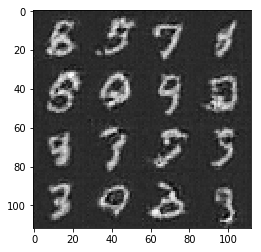

Epoch 2/2... Discriminator Loss: 0.2069... Generator Loss: 2.3184
Epoch 2/2... Discriminator Loss: 0.5294... Generator Loss: 1.2108
Epoch 2/2... Discriminator Loss: 0.2178... Generator Loss: 2.0616
Epoch 2/2... Discriminator Loss: 0.0590... Generator Loss: 4.3596
Epoch 2/2... Discriminator Loss: 0.1239... Generator Loss: 2.7817
Epoch 2/2... Discriminator Loss: 0.0666... Generator Loss: 4.0100
Epoch 2/2... Discriminator Loss: 0.0836... Generator Loss: 2.9754
Epoch 2/2... Discriminator Loss: 0.0720... Generator Loss: 3.5025
Epoch 2/2... Discriminator Loss: 0.0639... Generator Loss: 3.8704
Epoch 2/2... Discriminator Loss: 0.1390... Generator Loss: 2.6270


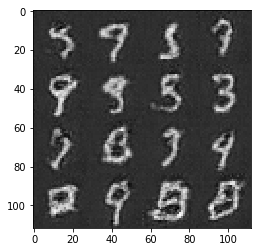

Epoch 2/2... Discriminator Loss: 0.0426... Generator Loss: 4.3880
Epoch 2/2... Discriminator Loss: 0.2625... Generator Loss: 3.4938
Epoch 2/2... Discriminator Loss: 0.5658... Generator Loss: 1.3302
Epoch 2/2... Discriminator Loss: 0.1956... Generator Loss: 2.5262
Epoch 2/2... Discriminator Loss: 0.3752... Generator Loss: 1.7512
Epoch 2/2... Discriminator Loss: 0.1400... Generator Loss: 3.2271
Epoch 2/2... Discriminator Loss: 0.1979... Generator Loss: 4.5426
Epoch 2/2... Discriminator Loss: 0.2691... Generator Loss: 1.8924
Epoch 2/2... Discriminator Loss: 0.1236... Generator Loss: 3.7126
Epoch 2/2... Discriminator Loss: 0.1759... Generator Loss: 2.5154


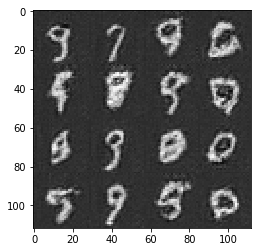

Epoch 2/2... Discriminator Loss: 0.2339... Generator Loss: 2.0111
Epoch 2/2... Discriminator Loss: 0.0975... Generator Loss: 3.5000
Epoch 2/2... Discriminator Loss: 0.1758... Generator Loss: 2.3594
Epoch 2/2... Discriminator Loss: 0.0647... Generator Loss: 3.6681
Epoch 2/2... Discriminator Loss: 0.1624... Generator Loss: 2.5358
Epoch 2/2... Discriminator Loss: 0.2336... Generator Loss: 4.1264
Epoch 2/2... Discriminator Loss: 0.0850... Generator Loss: 3.0110
Epoch 2/2... Discriminator Loss: 0.6338... Generator Loss: 1.2355
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 0.9529
Epoch 2/2... Discriminator Loss: 0.3831... Generator Loss: 1.6629


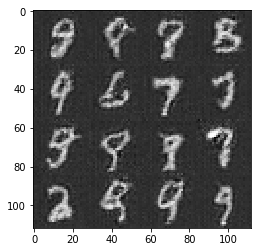

Epoch 2/2... Discriminator Loss: 0.4785... Generator Loss: 1.4573
Epoch 2/2... Discriminator Loss: 0.3741... Generator Loss: 1.7349
Epoch 2/2... Discriminator Loss: 0.4800... Generator Loss: 1.2454
Epoch 2/2... Discriminator Loss: 0.3735... Generator Loss: 1.5484
Epoch 2/2... Discriminator Loss: 0.1628... Generator Loss: 3.3150
Epoch 2/2... Discriminator Loss: 0.2833... Generator Loss: 2.2676
Epoch 2/2... Discriminator Loss: 0.3415... Generator Loss: 2.6296
Epoch 2/2... Discriminator Loss: 0.1307... Generator Loss: 3.0229
Epoch 2/2... Discriminator Loss: 0.1029... Generator Loss: 2.8981
Epoch 2/2... Discriminator Loss: 0.1536... Generator Loss: 3.7411


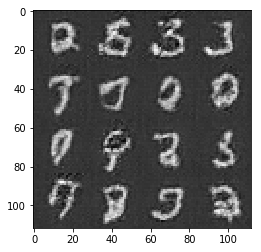

Epoch 2/2... Discriminator Loss: 0.0935... Generator Loss: 4.1076
Epoch 2/2... Discriminator Loss: 0.0912... Generator Loss: 3.3042
Epoch 2/2... Discriminator Loss: 0.0790... Generator Loss: 3.2579
Epoch 2/2... Discriminator Loss: 0.1588... Generator Loss: 2.4688
Epoch 2/2... Discriminator Loss: 0.1580... Generator Loss: 2.4709
Epoch 2/2... Discriminator Loss: 0.0843... Generator Loss: 3.2780
Epoch 2/2... Discriminator Loss: 0.1209... Generator Loss: 2.6602
Epoch 2/2... Discriminator Loss: 0.0847... Generator Loss: 3.3658
Epoch 2/2... Discriminator Loss: 0.0647... Generator Loss: 4.5678
Epoch 2/2... Discriminator Loss: 0.0912... Generator Loss: 4.2100


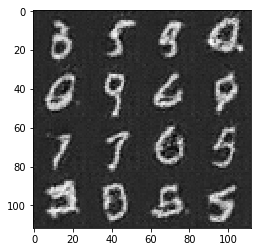

Epoch 2/2... Discriminator Loss: 0.0762... Generator Loss: 4.1632
Epoch 2/2... Discriminator Loss: 0.0928... Generator Loss: 2.9761
Epoch 2/2... Discriminator Loss: 0.0853... Generator Loss: 4.3162
Epoch 2/2... Discriminator Loss: 0.0598... Generator Loss: 3.7478
Epoch 2/2... Discriminator Loss: 0.3522... Generator Loss: 7.0356
Epoch 2/2... Discriminator Loss: 0.0844... Generator Loss: 3.7355
Epoch 2/2... Discriminator Loss: 0.0266... Generator Loss: 5.4621
Epoch 2/2... Discriminator Loss: 0.3547... Generator Loss: 6.0267
Epoch 2/2... Discriminator Loss: 0.0741... Generator Loss: 3.7237
Epoch 2/2... Discriminator Loss: 0.1678... Generator Loss: 3.5586


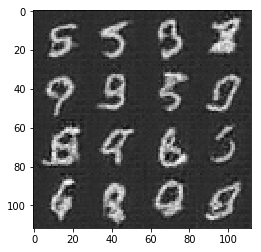

Epoch 2/2... Discriminator Loss: 0.0692... Generator Loss: 3.6604
Epoch 2/2... Discriminator Loss: 0.0926... Generator Loss: 3.2488
Epoch 2/2... Discriminator Loss: 0.1290... Generator Loss: 2.9754
Epoch 2/2... Discriminator Loss: 0.0958... Generator Loss: 3.3880
Epoch 2/2... Discriminator Loss: 0.1099... Generator Loss: 5.0016
Epoch 2/2... Discriminator Loss: 0.2052... Generator Loss: 4.9833
Epoch 2/2... Discriminator Loss: 0.0853... Generator Loss: 3.6677
Epoch 2/2... Discriminator Loss: 0.0742... Generator Loss: 3.9326
Epoch 2/2... Discriminator Loss: 0.0625... Generator Loss: 4.0143
Epoch 2/2... Discriminator Loss: 0.0735... Generator Loss: 6.1587


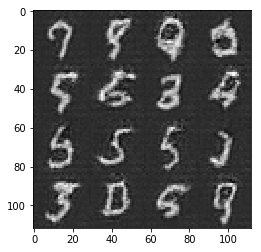

Epoch 2/2... Discriminator Loss: 0.0434... Generator Loss: 3.9838
Epoch 2/2... Discriminator Loss: 0.0716... Generator Loss: 3.3971
Epoch 2/2... Discriminator Loss: 0.4256... Generator Loss: 1.3352
Epoch 2/2... Discriminator Loss: 0.0741... Generator Loss: 3.3899
Epoch 2/2... Discriminator Loss: 0.3780... Generator Loss: 1.6359


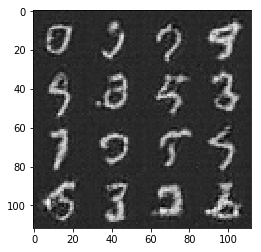

In [89]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.1132... Generator Loss: 0.0139
Epoch 1/1... Discriminator Loss: 4.8135... Generator Loss: 0.0186
Epoch 1/1... Discriminator Loss: 3.2066... Generator Loss: 0.1357
Epoch 1/1... Discriminator Loss: 2.8498... Generator Loss: 0.1597
Epoch 1/1... Discriminator Loss: 2.1986... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 1.8450... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.6095... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 0.9401


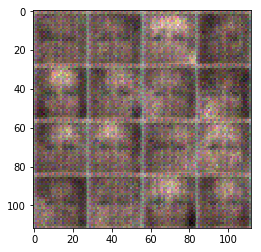

Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 2.2081
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 2.5730
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.4353
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 2.2553
Epoch 1/1... Discriminator Loss: 0.4306... Generator Loss: 4.3759
Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 1.7907
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 2.9380


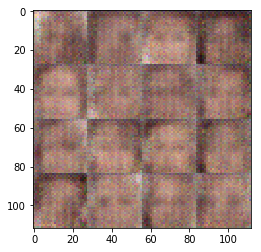

Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 6.0233
Epoch 1/1... Discriminator Loss: 0.3765... Generator Loss: 6.7728
Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 0.3215... Generator Loss: 1.7834
Epoch 1/1... Discriminator Loss: 2.0570... Generator Loss: 0.1738
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 3.5237
Epoch 1/1... Discriminator Loss: 0.2301... Generator Loss: 6.4616
Epoch 1/1... Discriminator Loss: 1.7841... Generator Loss: 0.2401
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 1.0716


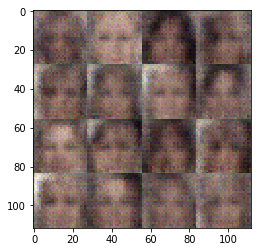

Epoch 1/1... Discriminator Loss: 2.5228... Generator Loss: 0.0962
Epoch 1/1... Discriminator Loss: 1.8728... Generator Loss: 0.2518
Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 1.6439
Epoch 1/1... Discriminator Loss: 0.1836... Generator Loss: 7.7256
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 1.9681
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 0.1329... Generator Loss: 5.2980
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 3.4212
Epoch 1/1... Discriminator Loss: 2.1440... Generator Loss: 0.1510
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 6.9495


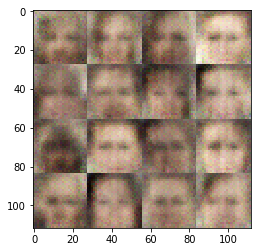

Epoch 1/1... Discriminator Loss: 0.1482... Generator Loss: 3.4971
Epoch 1/1... Discriminator Loss: 0.2867... Generator Loss: 4.1929
Epoch 1/1... Discriminator Loss: 0.2148... Generator Loss: 5.1157
Epoch 1/1... Discriminator Loss: 0.2690... Generator Loss: 11.9084
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 2.7244
Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 6.8364
Epoch 1/1... Discriminator Loss: 0.1590... Generator Loss: 11.7878
Epoch 1/1... Discriminator Loss: 1.7933... Generator Loss: 0.2315
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 2.3783


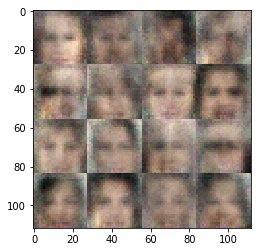

Epoch 1/1... Discriminator Loss: 0.3036... Generator Loss: 5.7598
Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 5.6962
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 0.2658... Generator Loss: 5.3248
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.3224
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.3182
Epoch 1/1... Discriminator Loss: 1.9427... Generator Loss: 0.2125
Epoch 1/1... Discriminator Loss: 2.0245... Generator Loss: 0.1866
Epoch 1/1... Discriminator Loss: 0.1595... Generator Loss: 6.2369
Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 2.5751


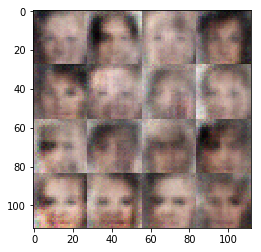

Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 0.4870... Generator Loss: 5.1647
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 0.2007... Generator Loss: 2.6854
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.3141
Epoch 1/1... Discriminator Loss: 0.2218... Generator Loss: 2.9070
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 3.2120
Epoch 1/1... Discriminator Loss: 0.1583... Generator Loss: 6.9200
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 0.3058... Generator Loss: 1.6847


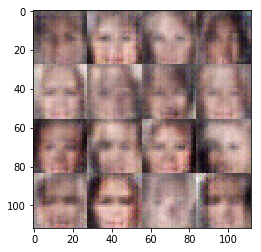

Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 0.2746... Generator Loss: 8.7287
Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 2.0194
Epoch 1/1... Discriminator Loss: 0.3307... Generator Loss: 2.2340
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 4.7468
Epoch 1/1... Discriminator Loss: 0.2265... Generator Loss: 2.8300
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 1.2834
Epoch 1/1... Discriminator Loss: 0.1012... Generator Loss: 3.8155
Epoch 1/1... Discriminator Loss: 0.2263... Generator Loss: 2.4019
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 0.2412


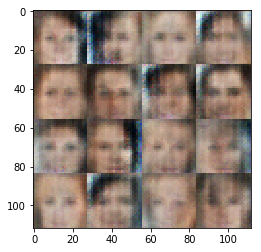

Epoch 1/1... Discriminator Loss: 0.1563... Generator Loss: 2.8523
Epoch 1/1... Discriminator Loss: 0.2840... Generator Loss: 2.1833
Epoch 1/1... Discriminator Loss: 2.1236... Generator Loss: 0.1485
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 7.7223
Epoch 1/1... Discriminator Loss: 0.1577... Generator Loss: 10.9785
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 3.0058
Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 3.9680
Epoch 1/1... Discriminator Loss: 0.5650... Generator Loss: 2.6905
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 0.7911


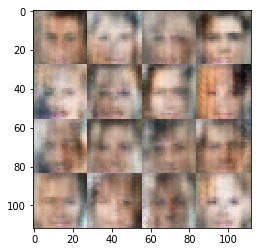

Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 5.3755
Epoch 1/1... Discriminator Loss: 0.1536... Generator Loss: 7.6727
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 2.6421
Epoch 1/1... Discriminator Loss: 1.6459... Generator Loss: 0.2687
Epoch 1/1... Discriminator Loss: 0.0634... Generator Loss: 9.4159
Epoch 1/1... Discriminator Loss: 0.0691... Generator Loss: 6.6638
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 8.9391
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 0.1514... Generator Loss: 5.2634
Epoch 1/1... Discriminator Loss: 0.2006... Generator Loss: 2.7094


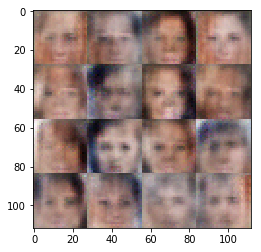

Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 2.0707
Epoch 1/1... Discriminator Loss: 0.2467... Generator Loss: 2.5717
Epoch 1/1... Discriminator Loss: 0.0676... Generator Loss: 6.0941
Epoch 1/1... Discriminator Loss: 0.1363... Generator Loss: 5.1676
Epoch 1/1... Discriminator Loss: 0.1871... Generator Loss: 9.0522
Epoch 1/1... Discriminator Loss: 0.1366... Generator Loss: 9.4759
Epoch 1/1... Discriminator Loss: 0.2665... Generator Loss: 5.2503
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 3.8038
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 4.9830
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 4.9095


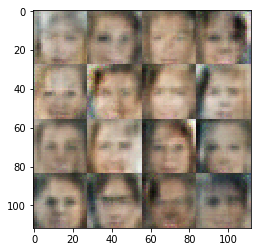

Epoch 1/1... Discriminator Loss: 0.1569... Generator Loss: 4.4194
Epoch 1/1... Discriminator Loss: 0.2110... Generator Loss: 2.9328
Epoch 1/1... Discriminator Loss: 0.1628... Generator Loss: 5.3584
Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 2.8990
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 3.6848
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.3554
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 3.6090
Epoch 1/1... Discriminator Loss: 0.5109... Generator Loss: 1.8856
Epoch 1/1... Discriminator Loss: 0.0968... Generator Loss: 11.3318
Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 5.0983


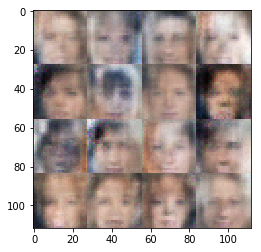

Epoch 1/1... Discriminator Loss: 0.1165... Generator Loss: 5.9071
Epoch 1/1... Discriminator Loss: 0.2841... Generator Loss: 2.4775
Epoch 1/1... Discriminator Loss: 0.1148... Generator Loss: 4.2865
Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 2.1407
Epoch 1/1... Discriminator Loss: 0.1456... Generator Loss: 5.4355
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 3.5025
Epoch 1/1... Discriminator Loss: 0.1060... Generator Loss: 8.0181
Epoch 1/1... Discriminator Loss: 0.1193... Generator Loss: 5.1326
Epoch 1/1... Discriminator Loss: 0.0826... Generator Loss: 6.5833
Epoch 1/1... Discriminator Loss: 0.1232... Generator Loss: 5.3806


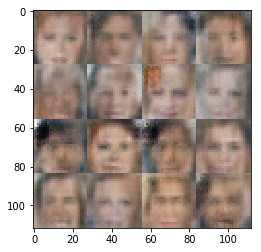

Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 6.8842
Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 2.1641
Epoch 1/1... Discriminator Loss: 0.1708... Generator Loss: 2.9827
Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 8.2462
Epoch 1/1... Discriminator Loss: 0.1041... Generator Loss: 5.5398
Epoch 1/1... Discriminator Loss: 0.1131... Generator Loss: 6.0855
Epoch 1/1... Discriminator Loss: 0.1426... Generator Loss: 8.6017
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 7.4386
Epoch 1/1... Discriminator Loss: 0.1959... Generator Loss: 3.9004


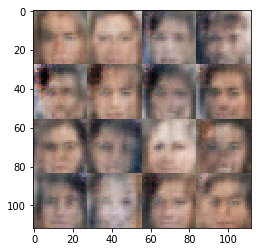

Epoch 1/1... Discriminator Loss: 0.2171... Generator Loss: 6.7838
Epoch 1/1... Discriminator Loss: 0.1882... Generator Loss: 3.8147
Epoch 1/1... Discriminator Loss: 0.2057... Generator Loss: 3.1596
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 3.4154
Epoch 1/1... Discriminator Loss: 0.6986... Generator Loss: 7.2770
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 1.4687
Epoch 1/1... Discriminator Loss: 0.0226... Generator Loss: 11.3276
Epoch 1/1... Discriminator Loss: 0.0673... Generator Loss: 7.0718
Epoch 1/1... Discriminator Loss: 0.1527... Generator Loss: 5.1305


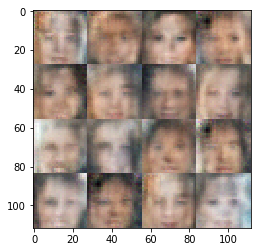

Epoch 1/1... Discriminator Loss: 0.3681... Generator Loss: 2.0219
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 3.7938
Epoch 1/1... Discriminator Loss: 0.1805... Generator Loss: 9.3937
Epoch 1/1... Discriminator Loss: 0.1201... Generator Loss: 4.2169
Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 2.7154
Epoch 1/1... Discriminator Loss: 0.1034... Generator Loss: 5.8484
Epoch 1/1... Discriminator Loss: 0.1555... Generator Loss: 8.1233
Epoch 1/1... Discriminator Loss: 0.2612... Generator Loss: 3.7363
Epoch 1/1... Discriminator Loss: 0.2117... Generator Loss: 4.6089
Epoch 1/1... Discriminator Loss: 0.1978... Generator Loss: 5.6505


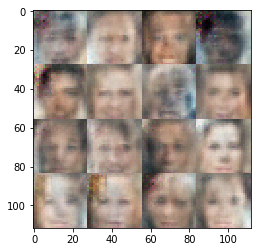

Epoch 1/1... Discriminator Loss: 0.0984... Generator Loss: 8.5674
Epoch 1/1... Discriminator Loss: 0.0553... Generator Loss: 7.9694
Epoch 1/1... Discriminator Loss: 0.2771... Generator Loss: 4.3815
Epoch 1/1... Discriminator Loss: 0.1644... Generator Loss: 7.0561
Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 4.5139
Epoch 1/1... Discriminator Loss: 0.1236... Generator Loss: 5.7735
Epoch 1/1... Discriminator Loss: 0.1633... Generator Loss: 4.8523
Epoch 1/1... Discriminator Loss: 0.2358... Generator Loss: 6.9569
Epoch 1/1... Discriminator Loss: 0.1450... Generator Loss: 6.3827
Epoch 1/1... Discriminator Loss: 0.3605... Generator Loss: 2.8234


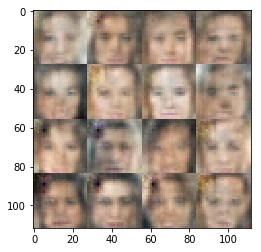

Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 4.8493
Epoch 1/1... Discriminator Loss: 0.2169... Generator Loss: 4.9463
Epoch 1/1... Discriminator Loss: 0.2074... Generator Loss: 4.0701
Epoch 1/1... Discriminator Loss: 0.1044... Generator Loss: 9.1629
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 1.2304
Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 10.3968
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 0.1382... Generator Loss: 5.6406
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 0.2173... Generator Loss: 3.5122


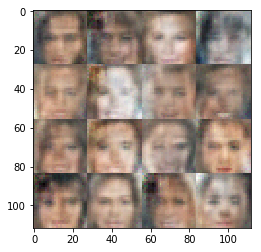

Epoch 1/1... Discriminator Loss: 0.1595... Generator Loss: 5.2448
Epoch 1/1... Discriminator Loss: 0.2548... Generator Loss: 9.6730
Epoch 1/1... Discriminator Loss: 0.1159... Generator Loss: 8.4372
Epoch 1/1... Discriminator Loss: 0.0836... Generator Loss: 4.5087
Epoch 1/1... Discriminator Loss: 0.1671... Generator Loss: 5.2663
Epoch 1/1... Discriminator Loss: 0.2330... Generator Loss: 2.4660
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 0.2943... Generator Loss: 2.6167
Epoch 1/1... Discriminator Loss: 0.2090... Generator Loss: 2.9361
Epoch 1/1... Discriminator Loss: 0.1971... Generator Loss: 6.2881


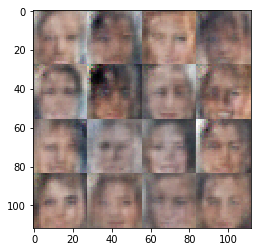

Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.6899
Epoch 1/1... Discriminator Loss: 0.1374... Generator Loss: 9.6554
Epoch 1/1... Discriminator Loss: 0.2661... Generator Loss: 3.2025
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.3786
Epoch 1/1... Discriminator Loss: 0.1934... Generator Loss: 8.3722
Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 5.4055
Epoch 1/1... Discriminator Loss: 0.2430... Generator Loss: 6.1682
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 2.0762
Epoch 1/1... Discriminator Loss: 0.2045... Generator Loss: 4.5842
Epoch 1/1... Discriminator Loss: 0.1518... Generator Loss: 8.4532


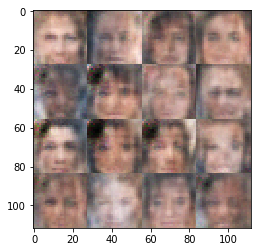

Epoch 1/1... Discriminator Loss: 0.1975... Generator Loss: 11.2291
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 8.8650
Epoch 1/1... Discriminator Loss: 0.0776... Generator Loss: 9.6651
Epoch 1/1... Discriminator Loss: 0.2312... Generator Loss: 5.9969
Epoch 1/1... Discriminator Loss: 0.1521... Generator Loss: 4.0749
Epoch 1/1... Discriminator Loss: 0.1065... Generator Loss: 5.2538
Epoch 1/1... Discriminator Loss: 0.2158... Generator Loss: 3.8313
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 6.2258
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 7.0397
Epoch 1/1... Discriminator Loss: 0.1498... Generator Loss: 5.8370


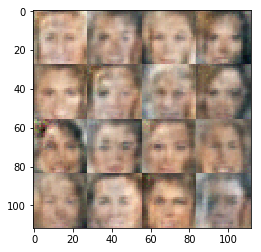

Epoch 1/1... Discriminator Loss: 0.1850... Generator Loss: 6.6524
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 6.7963
Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 15.6334
Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 5.9110
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 2.1997
Epoch 1/1... Discriminator Loss: 0.0806... Generator Loss: 5.8972
Epoch 1/1... Discriminator Loss: 0.2019... Generator Loss: 10.5414
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 2.0173
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 9.1354
Epoch 1/1... Discriminator Loss: 0.0744... Generator Loss: 7.0813


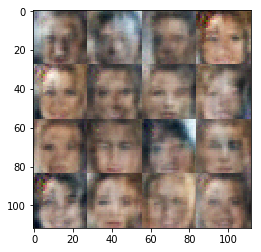

Epoch 1/1... Discriminator Loss: 0.0784... Generator Loss: 11.4790
Epoch 1/1... Discriminator Loss: 0.6618... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 0.1204... Generator Loss: 13.8935
Epoch 1/1... Discriminator Loss: 0.3511... Generator Loss: 2.4603
Epoch 1/1... Discriminator Loss: 0.0459... Generator Loss: 9.9451
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 5.8570
Epoch 1/1... Discriminator Loss: 0.1051... Generator Loss: 7.7239
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 3.3584
Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 4.7082


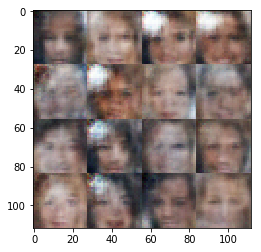

Epoch 1/1... Discriminator Loss: 0.2104... Generator Loss: 4.5057
Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 5.6583
Epoch 1/1... Discriminator Loss: 1.7958... Generator Loss: 0.2690
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 0.2929... Generator Loss: 3.0177
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 3.0694
Epoch 1/1... Discriminator Loss: 0.1550... Generator Loss: 4.1009
Epoch 1/1... Discriminator Loss: 0.3428... Generator Loss: 1.9910
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 4.2817
Epoch 1/1... Discriminator Loss: 0.3119... Generator Loss: 3.2530


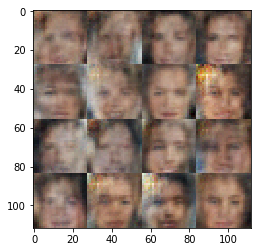

Epoch 1/1... Discriminator Loss: 0.1247... Generator Loss: 7.7872
Epoch 1/1... Discriminator Loss: 0.1391... Generator Loss: 5.3765
Epoch 1/1... Discriminator Loss: 0.1057... Generator Loss: 6.2852
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 1.4861
Epoch 1/1... Discriminator Loss: 0.1601... Generator Loss: 4.7343
Epoch 1/1... Discriminator Loss: 0.1306... Generator Loss: 6.4649
Epoch 1/1... Discriminator Loss: 0.4199... Generator Loss: 2.8034
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 1.9496
Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 1.4495
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 1.8995


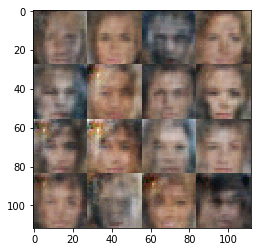

Epoch 1/1... Discriminator Loss: 0.0926... Generator Loss: 8.1845
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 0.2226... Generator Loss: 5.7901
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 2.2866
Epoch 1/1... Discriminator Loss: 0.1316... Generator Loss: 6.6282
Epoch 1/1... Discriminator Loss: 0.1708... Generator Loss: 6.4931
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.4674
Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 0.0956... Generator Loss: 9.6379
Epoch 1/1... Discriminator Loss: 0.1297... Generator Loss: 8.4387


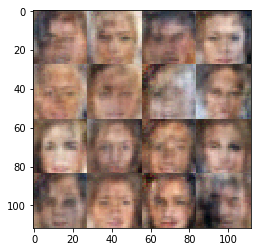

Epoch 1/1... Discriminator Loss: 0.1474... Generator Loss: 4.0845
Epoch 1/1... Discriminator Loss: 0.2433... Generator Loss: 6.4601
Epoch 1/1... Discriminator Loss: 0.1131... Generator Loss: 7.4685
Epoch 1/1... Discriminator Loss: 0.1463... Generator Loss: 14.8507
Epoch 1/1... Discriminator Loss: 0.1082... Generator Loss: 8.3488
Epoch 1/1... Discriminator Loss: 0.1167... Generator Loss: 7.0196
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 2.2499
Epoch 1/1... Discriminator Loss: 0.1125... Generator Loss: 10.3743
Epoch 1/1... Discriminator Loss: 0.0487... Generator Loss: 8.6107
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.3136


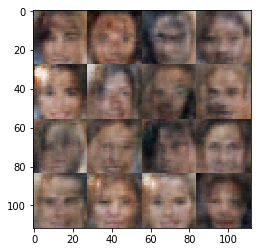

Epoch 1/1... Discriminator Loss: 0.1858... Generator Loss: 3.4798
Epoch 1/1... Discriminator Loss: 0.0805... Generator Loss: 11.2860
Epoch 1/1... Discriminator Loss: 0.0808... Generator Loss: 9.9712
Epoch 1/1... Discriminator Loss: 0.0711... Generator Loss: 10.7377
Epoch 1/1... Discriminator Loss: 0.1916... Generator Loss: 6.8195
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 3.5128
Epoch 1/1... Discriminator Loss: 0.1422... Generator Loss: 7.5554
Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 8.2341
Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 7.9989
Epoch 1/1... Discriminator Loss: 0.1977... Generator Loss: 5.1072


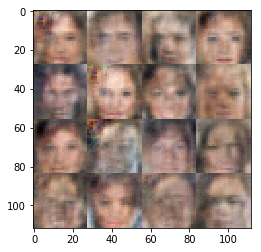

Epoch 1/1... Discriminator Loss: 0.1977... Generator Loss: 9.0361
Epoch 1/1... Discriminator Loss: 0.1058... Generator Loss: 7.6672
Epoch 1/1... Discriminator Loss: 0.1454... Generator Loss: 8.5792
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.5512
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 14.0487
Epoch 1/1... Discriminator Loss: 0.1087... Generator Loss: 10.2257
Epoch 1/1... Discriminator Loss: 0.2326... Generator Loss: 5.4393
Epoch 1/1... Discriminator Loss: 0.2344... Generator Loss: 7.5137
Epoch 1/1... Discriminator Loss: 0.2681... Generator Loss: 6.3613
Epoch 1/1... Discriminator Loss: 0.1671... Generator Loss: 7.6610


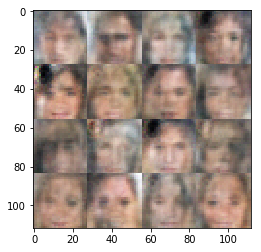

Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 10.7974
Epoch 1/1... Discriminator Loss: 0.1240... Generator Loss: 6.7991
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 7.4407
Epoch 1/1... Discriminator Loss: 0.2047... Generator Loss: 6.4465
Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 3.3761
Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 1.7708
Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 2.2876
Epoch 1/1... Discriminator Loss: 0.0669... Generator Loss: 7.4930
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 0.1115... Generator Loss: 9.5696


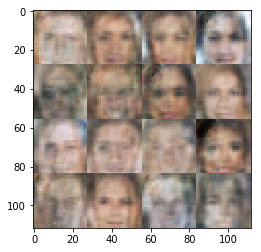

Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 2.0409
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 1.9961
Epoch 1/1... Discriminator Loss: 0.0906... Generator Loss: 8.0426
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 1.6247
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 2.9264
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 2.2226
Epoch 1/1... Discriminator Loss: 0.1457... Generator Loss: 6.6583
Epoch 1/1... Discriminator Loss: 0.1572... Generator Loss: 9.2385
Epoch 1/1... Discriminator Loss: 0.2502... Generator Loss: 2.9377
Epoch 1/1... Discriminator Loss: 0.1074... Generator Loss: 6.7455


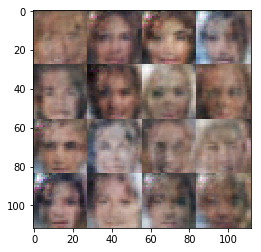

Epoch 1/1... Discriminator Loss: 0.1346... Generator Loss: 5.9756
Epoch 1/1... Discriminator Loss: 0.2145... Generator Loss: 5.3216
Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 8.9204
Epoch 1/1... Discriminator Loss: 0.2968... Generator Loss: 2.7230
Epoch 1/1... Discriminator Loss: 0.3143... Generator Loss: 3.1227
Epoch 1/1... Discriminator Loss: 0.1038... Generator Loss: 9.6390
Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 6.3795
Epoch 1/1... Discriminator Loss: 0.0673... Generator Loss: 7.6140
Epoch 1/1... Discriminator Loss: 0.1220... Generator Loss: 6.8840
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 2.2224


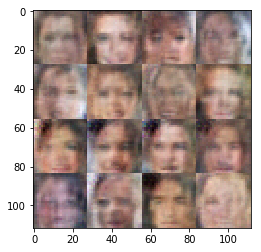

Epoch 1/1... Discriminator Loss: 0.1691... Generator Loss: 6.4531
Epoch 1/1... Discriminator Loss: 0.1268... Generator Loss: 7.2375
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 18.6455
Epoch 1/1... Discriminator Loss: 0.0869... Generator Loss: 9.6847
Epoch 1/1... Discriminator Loss: 0.1090... Generator Loss: 11.5870
Epoch 1/1... Discriminator Loss: 0.1040... Generator Loss: 4.8756
Epoch 1/1... Discriminator Loss: 0.1070... Generator Loss: 5.7647
Epoch 1/1... Discriminator Loss: 0.2747... Generator Loss: 5.8150
Epoch 1/1... Discriminator Loss: 0.1990... Generator Loss: 6.3378
Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 8.7860


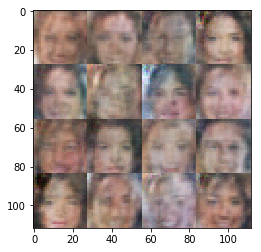

Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 1.8346
Epoch 1/1... Discriminator Loss: 0.1379... Generator Loss: 11.2458
Epoch 1/1... Discriminator Loss: 0.0888... Generator Loss: 9.8308
Epoch 1/1... Discriminator Loss: 0.1134... Generator Loss: 4.8887
Epoch 1/1... Discriminator Loss: 0.1795... Generator Loss: 7.9264
Epoch 1/1... Discriminator Loss: 0.1606... Generator Loss: 10.9154
Epoch 1/1... Discriminator Loss: 0.3541... Generator Loss: 3.2900
Epoch 1/1... Discriminator Loss: 1.9307... Generator Loss: 2.3141
Epoch 1/1... Discriminator Loss: 0.3038... Generator Loss: 5.5597
Epoch 1/1... Discriminator Loss: 0.1707... Generator Loss: 4.6359


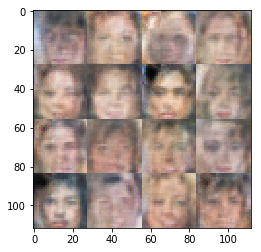

Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 3.3648
Epoch 1/1... Discriminator Loss: 0.1618... Generator Loss: 5.3859
Epoch 1/1... Discriminator Loss: 0.1550... Generator Loss: 6.4882
Epoch 1/1... Discriminator Loss: 0.1679... Generator Loss: 9.8479
Epoch 1/1... Discriminator Loss: 0.2360... Generator Loss: 2.3787
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 0.0997... Generator Loss: 7.0468
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 5.0592
Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 5.4006
Epoch 1/1... Discriminator Loss: 0.1379... Generator Loss: 7.2570


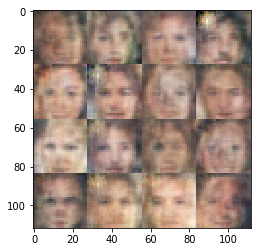

Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 3.7784
Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 2.7453
Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 2.3684
Epoch 1/1... Discriminator Loss: 0.0846... Generator Loss: 8.5259
Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 9.0261
Epoch 1/1... Discriminator Loss: 0.1362... Generator Loss: 9.4685
Epoch 1/1... Discriminator Loss: 0.2737... Generator Loss: 2.9526
Epoch 1/1... Discriminator Loss: 0.2068... Generator Loss: 2.7619
Epoch 1/1... Discriminator Loss: 0.0844... Generator Loss: 7.4759
Epoch 1/1... Discriminator Loss: 0.0981... Generator Loss: 8.9572


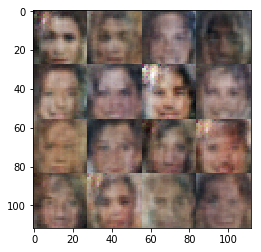

Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 0.1758... Generator Loss: 4.0566
Epoch 1/1... Discriminator Loss: 0.1499... Generator Loss: 6.1153
Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 9.6765
Epoch 1/1... Discriminator Loss: 0.2018... Generator Loss: 4.8783
Epoch 1/1... Discriminator Loss: 0.3041... Generator Loss: 4.5787
Epoch 1/1... Discriminator Loss: 0.1175... Generator Loss: 6.3613
Epoch 1/1... Discriminator Loss: 0.1393... Generator Loss: 7.0690
Epoch 1/1... Discriminator Loss: 0.1322... Generator Loss: 6.1365
Epoch 1/1... Discriminator Loss: 0.2086... Generator Loss: 3.6934


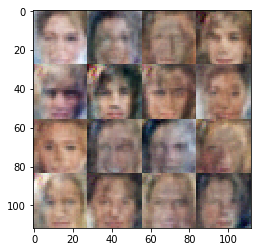

Epoch 1/1... Discriminator Loss: 0.1533... Generator Loss: 7.5475
Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 1.3725
Epoch 1/1... Discriminator Loss: 0.1762... Generator Loss: 5.4262
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 3.5521
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 0.0712... Generator Loss: 9.1460
Epoch 1/1... Discriminator Loss: 0.0850... Generator Loss: 7.0231
Epoch 1/1... Discriminator Loss: 0.0975... Generator Loss: 10.0099
Epoch 1/1... Discriminator Loss: 0.1248... Generator Loss: 6.7161
Epoch 1/1... Discriminator Loss: 0.2038... Generator Loss: 4.4771


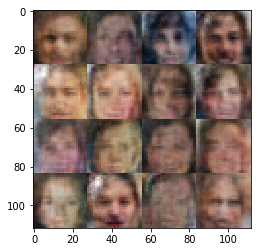

Epoch 1/1... Discriminator Loss: 0.6874... Generator Loss: 1.2827
Epoch 1/1... Discriminator Loss: 0.1962... Generator Loss: 6.4910
Epoch 1/1... Discriminator Loss: 0.2431... Generator Loss: 3.0076
Epoch 1/1... Discriminator Loss: 0.1768... Generator Loss: 5.8042
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 7.5846
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 2.4904
Epoch 1/1... Discriminator Loss: 0.1194... Generator Loss: 14.3019
Epoch 1/1... Discriminator Loss: 0.1749... Generator Loss: 5.4867
Epoch 1/1... Discriminator Loss: 0.1927... Generator Loss: 9.3456
Epoch 1/1... Discriminator Loss: 0.0581... Generator Loss: 12.5630


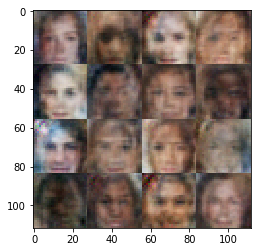

Epoch 1/1... Discriminator Loss: 0.0482... Generator Loss: 9.7715
Epoch 1/1... Discriminator Loss: 0.0989... Generator Loss: 8.3483
Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 6.7192
Epoch 1/1... Discriminator Loss: 0.1417... Generator Loss: 10.0739
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 3.1072
Epoch 1/1... Discriminator Loss: 0.3515... Generator Loss: 2.4577
Epoch 1/1... Discriminator Loss: 0.3131... Generator Loss: 4.8191
Epoch 1/1... Discriminator Loss: 0.1804... Generator Loss: 4.5457
Epoch 1/1... Discriminator Loss: 0.2862... Generator Loss: 5.5671
Epoch 1/1... Discriminator Loss: 0.1144... Generator Loss: 11.7021


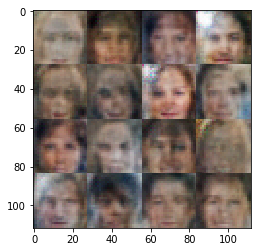

Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 0.0737... Generator Loss: 9.0610
Epoch 1/1... Discriminator Loss: 0.1587... Generator Loss: 8.4468
Epoch 1/1... Discriminator Loss: 0.1503... Generator Loss: 6.7801
Epoch 1/1... Discriminator Loss: 0.2712... Generator Loss: 10.1556
Epoch 1/1... Discriminator Loss: 0.1395... Generator Loss: 7.0133
Epoch 1/1... Discriminator Loss: 0.0675... Generator Loss: 8.4229
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 3.1317
Epoch 1/1... Discriminator Loss: 0.1497... Generator Loss: 7.2868
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 2.2379


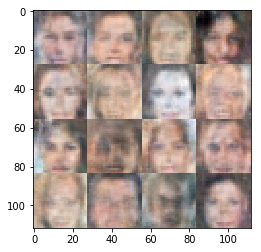

Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 6.3483
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 1.9034
Epoch 1/1... Discriminator Loss: 0.0682... Generator Loss: 11.5700
Epoch 1/1... Discriminator Loss: 0.1213... Generator Loss: 6.7409
Epoch 1/1... Discriminator Loss: 0.1882... Generator Loss: 3.8595
Epoch 1/1... Discriminator Loss: 0.3178... Generator Loss: 3.8488
Epoch 1/1... Discriminator Loss: 0.0789... Generator Loss: 12.6327
Epoch 1/1... Discriminator Loss: 0.0552... Generator Loss: 11.9080
Epoch 1/1... Discriminator Loss: 0.2441... Generator Loss: 8.8231
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.2719


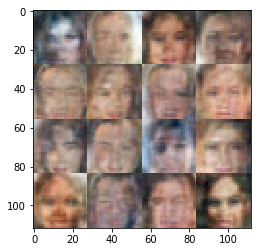

Epoch 1/1... Discriminator Loss: 0.0603... Generator Loss: 8.0322
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 2.4654
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 0.0776... Generator Loss: 6.0929
Epoch 1/1... Discriminator Loss: 0.1484... Generator Loss: 9.5105
Epoch 1/1... Discriminator Loss: 0.2589... Generator Loss: 3.9909
Epoch 1/1... Discriminator Loss: 0.3066... Generator Loss: 4.2543
Epoch 1/1... Discriminator Loss: 0.1151... Generator Loss: 6.5927
Epoch 1/1... Discriminator Loss: 0.2714... Generator Loss: 5.3298
Epoch 1/1... Discriminator Loss: 0.1214... Generator Loss: 6.3567


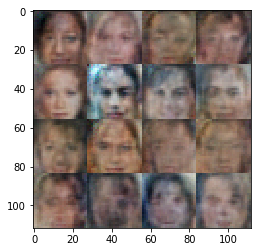

Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 12.3805
Epoch 1/1... Discriminator Loss: 0.1009... Generator Loss: 11.1791
Epoch 1/1... Discriminator Loss: 0.0747... Generator Loss: 7.0724
Epoch 1/1... Discriminator Loss: 0.3011... Generator Loss: 11.5993
Epoch 1/1... Discriminator Loss: 0.2817... Generator Loss: 6.1103
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 9.7995
Epoch 1/1... Discriminator Loss: 0.0547... Generator Loss: 6.8869
Epoch 1/1... Discriminator Loss: 0.1924... Generator Loss: 3.3290
Epoch 1/1... Discriminator Loss: 0.1494... Generator Loss: 5.6320
Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 1.7806


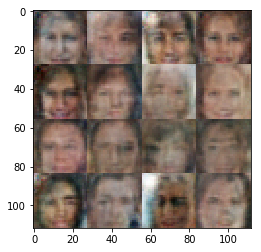

Epoch 1/1... Discriminator Loss: 0.0652... Generator Loss: 8.5906
Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 7.9789
Epoch 1/1... Discriminator Loss: 0.1552... Generator Loss: 7.2730
Epoch 1/1... Discriminator Loss: 0.1467... Generator Loss: 6.2461
Epoch 1/1... Discriminator Loss: 0.2324... Generator Loss: 5.8566
Epoch 1/1... Discriminator Loss: 0.1387... Generator Loss: 3.7896
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 1.8999
Epoch 1/1... Discriminator Loss: 0.1440... Generator Loss: 5.0702
Epoch 1/1... Discriminator Loss: 0.1004... Generator Loss: 6.4305
Epoch 1/1... Discriminator Loss: 0.0841... Generator Loss: 8.6999


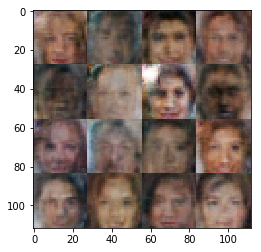

Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 9.5196
Epoch 1/1... Discriminator Loss: 0.2835... Generator Loss: 2.2163
Epoch 1/1... Discriminator Loss: 0.0781... Generator Loss: 7.1565
Epoch 1/1... Discriminator Loss: 0.0871... Generator Loss: 6.2572
Epoch 1/1... Discriminator Loss: 0.1043... Generator Loss: 7.1296
Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 5.7629
Epoch 1/1... Discriminator Loss: 0.0723... Generator Loss: 13.5591
Epoch 1/1... Discriminator Loss: 0.1093... Generator Loss: 5.8045
Epoch 1/1... Discriminator Loss: 0.1405... Generator Loss: 8.4841
Epoch 1/1... Discriminator Loss: 0.2529... Generator Loss: 4.1956


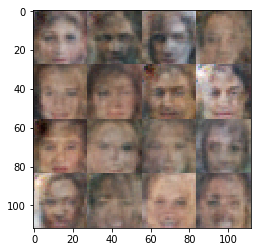

Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 8.8525
Epoch 1/1... Discriminator Loss: 0.1386... Generator Loss: 5.4219
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 0.1203... Generator Loss: 8.1381
Epoch 1/1... Discriminator Loss: 0.1382... Generator Loss: 9.8875
Epoch 1/1... Discriminator Loss: 1.5941... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 0.1764... Generator Loss: 6.4729
Epoch 1/1... Discriminator Loss: 0.2042... Generator Loss: 5.6993
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 2.2065


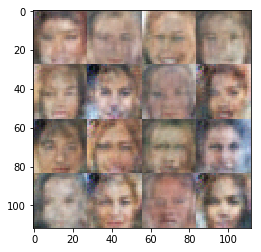

Epoch 1/1... Discriminator Loss: 0.1053... Generator Loss: 8.9504
Epoch 1/1... Discriminator Loss: 0.0813... Generator Loss: 12.3904
Epoch 1/1... Discriminator Loss: 0.1171... Generator Loss: 8.9182
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 1.7174
Epoch 1/1... Discriminator Loss: 0.0993... Generator Loss: 6.9267
Epoch 1/1... Discriminator Loss: 0.1403... Generator Loss: 5.2216
Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 9.0804
Epoch 1/1... Discriminator Loss: 0.1686... Generator Loss: 4.2608
Epoch 1/1... Discriminator Loss: 0.1750... Generator Loss: 5.5437
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 2.9621


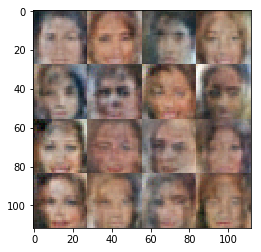

Epoch 1/1... Discriminator Loss: 0.1464... Generator Loss: 5.0785
Epoch 1/1... Discriminator Loss: 0.1065... Generator Loss: 17.4725
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 5.3617
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 0.1323... Generator Loss: 7.1693
Epoch 1/1... Discriminator Loss: 0.3793... Generator Loss: 2.8043
Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 14.4947
Epoch 1/1... Discriminator Loss: 0.1520... Generator Loss: 6.1756
Epoch 1/1... Discriminator Loss: 0.2437... Generator Loss: 4.4952
Epoch 1/1... Discriminator Loss: 0.2433... Generator Loss: 7.6817


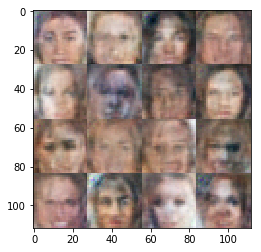

Epoch 1/1... Discriminator Loss: 0.3081... Generator Loss: 12.9707
Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 9.0547
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.5528
Epoch 1/1... Discriminator Loss: 0.2571... Generator Loss: 7.1695
Epoch 1/1... Discriminator Loss: 0.2103... Generator Loss: 9.6597
Epoch 1/1... Discriminator Loss: 0.1451... Generator Loss: 13.2820
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 7.6544
Epoch 1/1... Discriminator Loss: 0.1411... Generator Loss: 9.4417
Epoch 1/1... Discriminator Loss: 0.1405... Generator Loss: 5.0780
Epoch 1/1... Discriminator Loss: 0.3137... Generator Loss: 3.5184


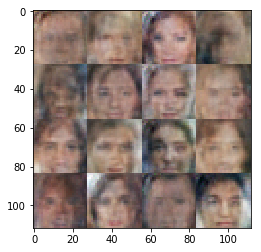

Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 1.3046
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 9.3730
Epoch 1/1... Discriminator Loss: 0.1216... Generator Loss: 4.6214
Epoch 1/1... Discriminator Loss: 1.6913... Generator Loss: 0.3277
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 0.1589... Generator Loss: 6.0196
Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 0.1682... Generator Loss: 4.6705
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 1.9881
Epoch 1/1... Discriminator Loss: 0.1624... Generator Loss: 6.7533


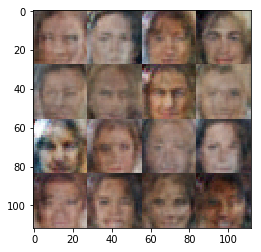

Epoch 1/1... Discriminator Loss: 0.2283... Generator Loss: 4.5915
Epoch 1/1... Discriminator Loss: 0.1566... Generator Loss: 5.8798
Epoch 1/1... Discriminator Loss: 0.1340... Generator Loss: 6.3805
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 1.8447
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 5.4089
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 2.0158
Epoch 1/1... Discriminator Loss: 0.1225... Generator Loss: 6.5560
Epoch 1/1... Discriminator Loss: 0.1843... Generator Loss: 4.0075
Epoch 1/1... Discriminator Loss: 0.0836... Generator Loss: 10.3225


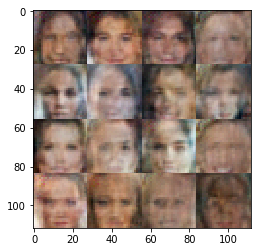

Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 2.7949
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 7.0758
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 1.5385
Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 4.6849
Epoch 1/1... Discriminator Loss: 0.3131... Generator Loss: 3.2204
Epoch 1/1... Discriminator Loss: 0.3068... Generator Loss: 1.7518
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 4.5228
Epoch 1/1... Discriminator Loss: 0.2164... Generator Loss: 4.0311


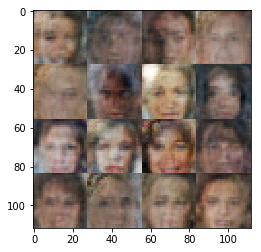

Epoch 1/1... Discriminator Loss: 0.0617... Generator Loss: 9.2017
Epoch 1/1... Discriminator Loss: 0.1845... Generator Loss: 4.9326
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 1.4036
Epoch 1/1... Discriminator Loss: 0.5601... Generator Loss: 2.1729
Epoch 1/1... Discriminator Loss: 0.0699... Generator Loss: 11.0577
Epoch 1/1... Discriminator Loss: 0.0806... Generator Loss: 8.1654
Epoch 1/1... Discriminator Loss: 0.1216... Generator Loss: 5.5422
Epoch 1/1... Discriminator Loss: 0.1319... Generator Loss: 5.2825
Epoch 1/1... Discriminator Loss: 0.1257... Generator Loss: 3.8642
Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 4.3351


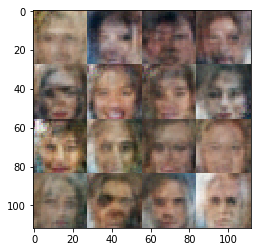

Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 2.6533
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 0.2103... Generator Loss: 3.0083
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 2.6716
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 0.1978... Generator Loss: 9.5281
Epoch 1/1... Discriminator Loss: 0.1962... Generator Loss: 5.2960
Epoch 1/1... Discriminator Loss: 0.0831... Generator Loss: 8.0433
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.1059... Generator Loss: 16.3647


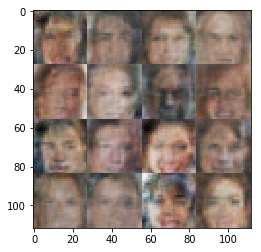

Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 4.5964
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 10.7929
Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 1.8640
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.4358
Epoch 1/1... Discriminator Loss: 0.0919... Generator Loss: 4.6971
Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 1.3431
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 2.8650
Epoch 1/1... Discriminator Loss: 0.1519... Generator Loss: 3.5314
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 8.4118


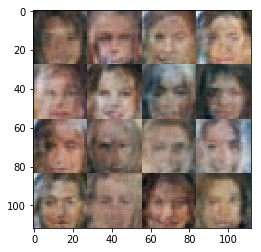

Epoch 1/1... Discriminator Loss: 0.2327... Generator Loss: 7.6485
Epoch 1/1... Discriminator Loss: 0.1602... Generator Loss: 7.1568
Epoch 1/1... Discriminator Loss: 0.0989... Generator Loss: 4.3853
Epoch 1/1... Discriminator Loss: 0.0744... Generator Loss: 6.1037
Epoch 1/1... Discriminator Loss: 0.1025... Generator Loss: 8.0126
Epoch 1/1... Discriminator Loss: 0.1945... Generator Loss: 4.9613
Epoch 1/1... Discriminator Loss: 0.0548... Generator Loss: 16.2710
Epoch 1/1... Discriminator Loss: 0.0907... Generator Loss: 6.0775
Epoch 1/1... Discriminator Loss: 0.1570... Generator Loss: 6.9227
Epoch 1/1... Discriminator Loss: 0.0881... Generator Loss: 7.2719


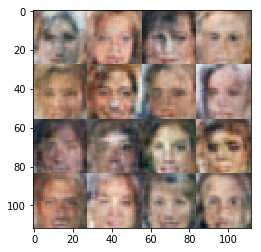

Epoch 1/1... Discriminator Loss: 0.3059... Generator Loss: 13.0396
Epoch 1/1... Discriminator Loss: 0.1554... Generator Loss: 7.5737
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 0.2542... Generator Loss: 4.4752
Epoch 1/1... Discriminator Loss: 0.2745... Generator Loss: 2.6131
Epoch 1/1... Discriminator Loss: 0.3163... Generator Loss: 2.8413
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 0.2346... Generator Loss: 3.4693
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 15.2117
Epoch 1/1... Discriminator Loss: 0.1608... Generator Loss: 5.5027


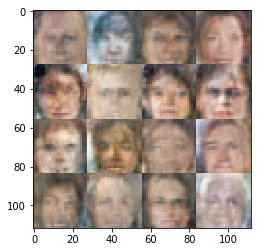

Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 5.9343
Epoch 1/1... Discriminator Loss: 0.0530... Generator Loss: 12.6319
Epoch 1/1... Discriminator Loss: 0.2167... Generator Loss: 6.0505
Epoch 1/1... Discriminator Loss: 0.0759... Generator Loss: 10.0668
Epoch 1/1... Discriminator Loss: 0.2956... Generator Loss: 3.8179
Epoch 1/1... Discriminator Loss: 2.1932... Generator Loss: 0.2859
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 3.4310
Epoch 1/1... Discriminator Loss: 0.1338... Generator Loss: 4.5194
Epoch 1/1... Discriminator Loss: 0.0839... Generator Loss: 8.6615
Epoch 1/1... Discriminator Loss: 0.1272... Generator Loss: 5.4553


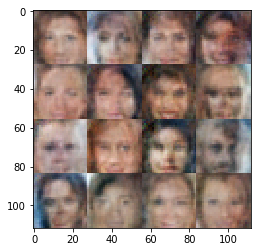

Epoch 1/1... Discriminator Loss: 0.1871... Generator Loss: 6.2492
Epoch 1/1... Discriminator Loss: 1.9701... Generator Loss: 0.2618
Epoch 1/1... Discriminator Loss: 0.2312... Generator Loss: 5.1664
Epoch 1/1... Discriminator Loss: 0.6588... Generator Loss: 1.6316
Epoch 1/1... Discriminator Loss: 0.1229... Generator Loss: 12.8633
Epoch 1/1... Discriminator Loss: 0.0562... Generator Loss: 14.1139
Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 2.3028
Epoch 1/1... Discriminator Loss: 0.1935... Generator Loss: 9.8198
Epoch 1/1... Discriminator Loss: 0.1777... Generator Loss: 7.9474
Epoch 1/1... Discriminator Loss: 0.0883... Generator Loss: 9.4400


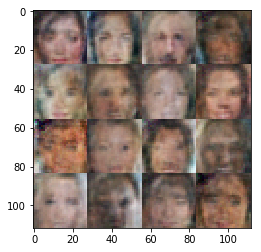

Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 2.9820
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 0.2277... Generator Loss: 4.4569
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 0.3089... Generator Loss: 2.3492
Epoch 1/1... Discriminator Loss: 0.1567... Generator Loss: 5.8751
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 0.0932... Generator Loss: 5.6182
Epoch 1/1... Discriminator Loss: 0.1893... Generator Loss: 12.4923
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 1.7967


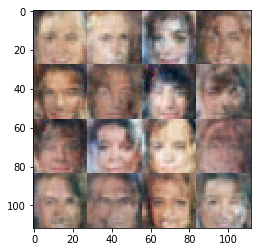

Epoch 1/1... Discriminator Loss: 0.1113... Generator Loss: 15.3435
Epoch 1/1... Discriminator Loss: 0.1533... Generator Loss: 5.8253
Epoch 1/1... Discriminator Loss: 0.1473... Generator Loss: 5.5972
Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 2.0960
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 0.0916... Generator Loss: 9.9589
Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 6.3099
Epoch 1/1... Discriminator Loss: 0.1109... Generator Loss: 8.8656
Epoch 1/1... Discriminator Loss: 0.1663... Generator Loss: 5.2516
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.7048


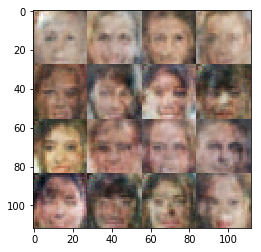

Epoch 1/1... Discriminator Loss: 0.1743... Generator Loss: 11.3383
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 3.2631
Epoch 1/1... Discriminator Loss: 0.0732... Generator Loss: 11.1626
Epoch 1/1... Discriminator Loss: 0.1655... Generator Loss: 6.3860
Epoch 1/1... Discriminator Loss: 0.1743... Generator Loss: 6.8136
Epoch 1/1... Discriminator Loss: 0.1861... Generator Loss: 6.5270
Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 1.6876
Epoch 1/1... Discriminator Loss: 0.4676... Generator Loss: 2.2568
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 3.7251
Epoch 1/1... Discriminator Loss: 0.2676... Generator Loss: 3.2493


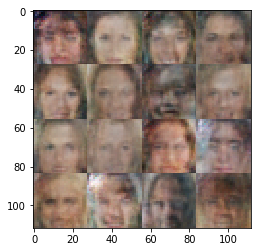

Epoch 1/1... Discriminator Loss: 0.1489... Generator Loss: 5.2802
Epoch 1/1... Discriminator Loss: 0.2138... Generator Loss: 8.5968
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 1.2604


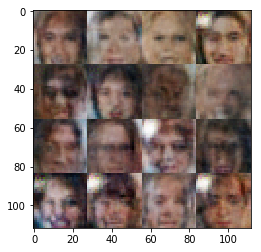

In [90]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.